# Question 3

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!tar -xvf  '/content/drive/MyDrive/maps.tar.gz'  -C '/content'
# %cp -r /content/maps_new  /content/drive/MyDrive/DL_Assignment_3/maps_new 

In [ ]:
import glob
from PIL import Image
import numpy as np

for file1 in glob.glob("/content/maps_old/train/*"):
    img = Image.open(file1)
    img = np.array(img)
    input = img[:,:600,:3]
    gt = img[:,600:,:3]
    
    input = Image.fromarray(input)
    gt = Image.fromarray(gt)

    input.save("/content/maps/train/inputs/"+file1.split("/")[-1])
    gt.save("/content/maps/train/ground_truths/"+file1.split("/")[-1])

for file1 in glob.glob("/content/maps_old/val/*"):
    img = Image.open(file1)
    img = np.array(img)
    input = img[:,:600,:3]
    gt = img[:,600:,:3]
    
    input = Image.fromarray(input)
    gt = Image.fromarray(gt)

    input.save("/content/maps/val/inputs/"+file1.split("/")[-1])
    gt.save("/content/maps/val/ground_truths/"+file1.split("/")[-1])

train_filepaths = []
for i in sorted(glob.glob("/content/maps/train/inputs/*")):
  train_filepaths.append([i,i.replace("inputs","ground_truths")]) 

train_filepaths = np.array(train_filepaths)
np.save("/content/maps/train/train_filepaths.npy",train_filepaths)

val_filepaths = []
for i in sorted(glob.glob("/content/maps/val/inputs/*")):
  val_filepaths.append([i,i.replace("inputs","ground_truths")]) 

val_filepaths = np.array(val_filepaths)
np.save("/content/maps/val/val_filepaths.npy",val_filepaths)

print(train_filepaths.shape)
print(val_filepaths.shape)



In [ ]:
class SatelliteDataset(Dataset):
  def __init__(self,filepaths,transform=None):

    self.npy_filepaths = np.load(filepaths)
    self.transform = transform

  def __len__(self):
    return len(self.npy_filepaths)

  def __getitem__(self,idx):
    input_img = cv2.imread(self.npy_filepaths[idx][0])
    input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)

    gt_img = cv2.imread(self.npy_filepaths[idx][1])
    gt_img = cv2.cvtColor(gt_img,cv2.COLOR_BGR2RGB)

    if self.transform:
      input_img = self.transform(input_img)
      gt_img = self.transform(gt_img)

    return input_img,gt_img



In [ ]:
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),
    T.CenterCrop((256, 256)),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = SatelliteDataset("/content/maps/train/train_filepaths.npy",transform=transform)
dataset_val = SatelliteDataset("/content/maps/val/val_filepaths.npy",transform=transform)

train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=10, shuffle=False)

In [ ]:
class SatteliteGenerator(nn.Module):
    def __init__(self):
        super(SatteliteGenerator, self).__init__()

        self.elayer1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.elayer2 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(128))
        self.elayer3 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(256))
        self.elayer4 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512))
        self.elayer5 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512))
        self.elayer6 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512))
        self.elayer7 = nn.Sequential(nn.LeakyReLU(0.2,inplace=True),nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False))
        
        self.dlayer1 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512),nn.Dropout(0.5))
        self.dlayer2 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512),nn.Dropout(0.5))
        self.dlayer3 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=512*2, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(512),nn.Dropout(0.5))        
        self.dlayer4 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=512*2, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(256))
        self.dlayer5 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=256*2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(128))
        self.dlayer6 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=128*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(64))
        self.dlayer7 = nn.Sequential(nn.ReLU(inplace=True),nn.ConvTranspose2d(in_channels=64*2, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),nn.Tanh())
    
    def forward(self, x):
        e1 = self.elayer1(x)
        e2 = self.elayer2(e1)
        e3 = self.elayer3(e2)
        e4 = self.elayer4(e3)
        e5 = self.elayer5(e4)
        e6 = self.elayer6(e5)
        latent_space = self.elayer7(e6)
        d1 = torch.cat([self.dlayer1(latent_space), e6], dim=1)
        d2 = torch.cat([self.dlayer2(d1), e5], dim=1)
        d3 = torch.cat([self.dlayer3(d2), e4], dim=1)
        d4 = torch.cat([self.dlayer4(d3), e3], dim=1)
        d5 = torch.cat([self.dlayer5(d4), e2], dim=1)
        d6 = torch.cat([self.dlayer6(d5), e1], dim=1)
        out = self.dlayer7(d6)
        return out

In [ ]:
class SatteliteDiscriminator(nn.Module):
    def __init__(self):
        super(SatteliteDiscriminator, self).__init__()
        
        self.discrim = nn.Sequential(
            nn.Conv2d(in_channels=3*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels= 128, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(128),nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),nn.BatchNorm2d(256),nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1, bias=False),nn.BatchNorm2d(512),nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, bias=False),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.discrim(x)

In [ ]:
device = ('cuda:0' if torch.cuda.is_available() else "cpu")
print("device:",device)


def intializingWeights(m):
    name = m.__class__.__name__
    if(name.find("Conv") > -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(name.find("BatchNorm") > -1):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

Generator_model = SatteliteGenerator()
Generator_model.apply(intializingWeights)
Generator_model = Generator_model.to(device)
print("Generator_model:",Generator_model)

Discriminator_model = SatteliteDiscriminator()  
Discriminator_model.apply(intializingWeights)
Discriminator_model = Discriminator_model.to(device)
print("Discriminator_model:",Discriminator_model)

print("\n")

learning_rate = 0.0002
Generator_optimizer = optim.Adam(Generator_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
Discriminator_optimizer = optim.Adam(Discriminator_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion1 = nn.BCELoss()
criterion2 = nn.L1Loss()
num_epochs = 23
D_losses_real = []
D_losses_fake = []
G_losses = []
D_losses = []

for epoch in range(num_epochs+1):

    for idx,batch in enumerate(train_dataloader):
        input_img , gt_img = batch
        input_img = input_img.float().to(device)
        gt_img = gt_img.float().to(device)

        Discriminator_optimizer.zero_grad()
        
        real_imgs = torch.cat([input_img, gt_img], dim=1).to(device)
        out = Discriminator_model(real_imgs) 
        lbls = torch.ones(size = out.shape, dtype=torch.float, device=device)
        
        Discriminator_loss_real = 1.0 * criterion1(out, lbls)
        Discriminator_loss_real.backward()

        D_losses_real.append(Discriminator_loss_real.item())

        gen = Generator_model(input_img).detach()
        fake_imgs = torch.cat([input_img, gen], dim=1)
        out = Discriminator_model(fake_imgs)
        lbls = torch.zeros(size = out.shape, dtype=torch.float, device=device) 
        Discriminator_loss_fake = 1.0 * criterion1(out, lbls) 
        Discriminator_loss_fake.backward()

        D_losses_fake.append(Discriminator_loss_fake.item())

        D_losses.append(Discriminator_loss_real.item()+Discriminator_loss_fake.item())
        Discriminator_optimizer.step()

 
        Generator_model.zero_grad()
        
        gen = Generator_model(input_img)
        generated_data = torch.cat([input_img, gen], dim=1)
        out = Discriminator_model(generated_data)
        lbls = torch.ones(size = out.shape, dtype=torch.float, device=device)
        
        Generator_loss = criterion2(out, lbls)*10
        G_losses.append(Generator_loss)
        Generator_loss.backward()
        Generator_optimizer.step()
        
    print("epoch:",epoch,"Discriminator_loss_fake:",Discriminator_loss_fake.item()/len(train_dataloader),"Discriminator_loss_real:",Discriminator_loss_real.item()/len(train_dataloader),"Generator_loss:",Generator_loss.item()/len(train_dataloader))  
    torch.save(Generator_model, "/content/drive/MyDrive/DL_Assignment_3/maps_new/Sattelite_Generator_new_final.pth")
    torch.save(Discriminator_model, "/content/drive/MyDrive/DL_Assignment_3/maps_new/Sattelite_Generator_new_final.pth")
    


Generator_model: SatteliteGenerator(
  (elayer1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (elayer2): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (elayer3): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (elayer4): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (elayer5): Sequential(
    (0): LeakyReLU(negative_slope=0.2, inplace=True)
    (1): Conv

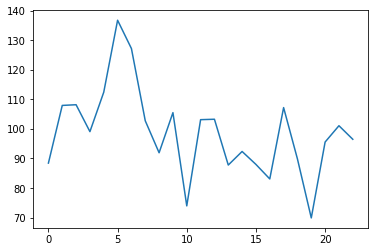

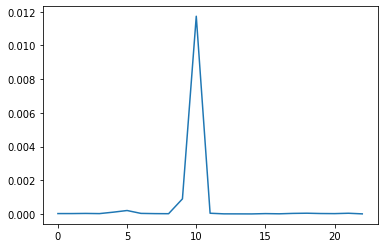

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
G_losses_new = np.array(G_losses)
np.save("G_losses_new.npy",G_losses)

D_losses_new = np.array(D_losses)
np.save("D_losses_new.npy",D_losses)

G_losses_new = np.load("/content/G_losses_new.npy",allow_pickle=True)
D_losses_new = np.load("/content/D_losses_new.npy",allow_pickle=True)

plt.plot(np.arange(num_epochs),G_losses_new)
plt.show()
plt.plot(np.arange(num_epochs),D_losses_new)
plt.show()

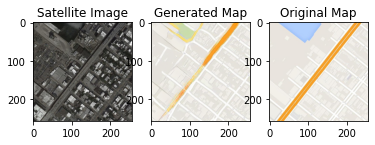

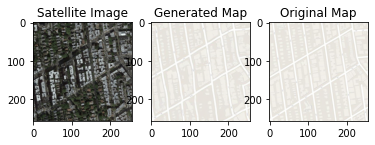

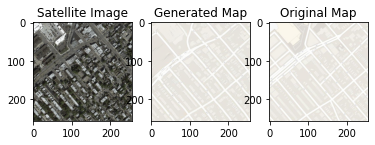

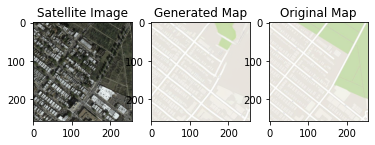

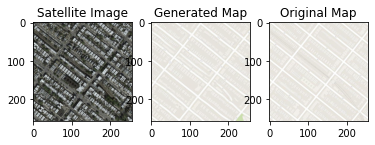

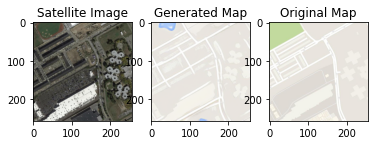

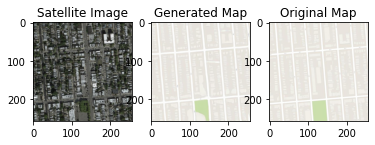

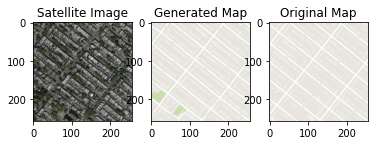

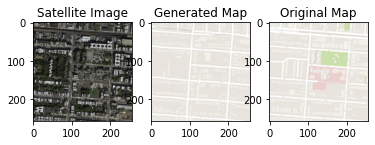

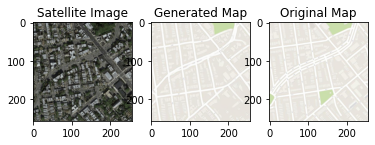

In [ ]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
Generator_model = torch.load("/content/drive/MyDrive/DL_Assignment_3/maps_new/Sattelite_Generator_new_final.pth")
Generator_model = Generator_model.to(device)

for idx,batch in enumerate(valid_dataloader):
        
    input_img , gt_img = batch
    input_img = input_img.float().to(device)

    generated_img = Generator_model(input_img)
    generated_img = generated_img.permute(0,2,3,1).detach().cpu().numpy()
    gt_img = gt_img.permute(0,2,3,1).detach().cpu().numpy()
    input_img = input_img.permute(0,2,3,1).detach().cpu().numpy()

    for i in range(10):
      input_img_i = input_img[i]
      generated_img_i = generated_img[i]
      gt_img_i = gt_img[i]
      fig, (ax1, ax2,ax3) = plt.subplots(1, 3)

      ax1.set_title('Satellite Image')
      ax2.set_title('Generated Map')
      ax3.set_title('Original Map')
      ax1.imshow(input_img_i)
      ax2.imshow(generated_img_i)
      ax3.imshow(gt_img_i)
      plt.show()
    
    break




SSIM:  0.7181356510962976


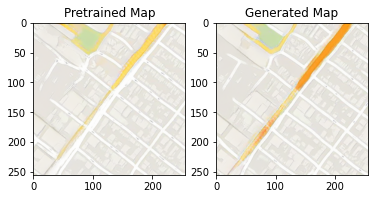

SSIM:  0.6836532688063852


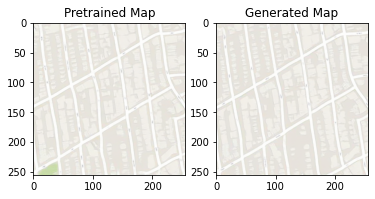

SSIM:  0.6686101742382943


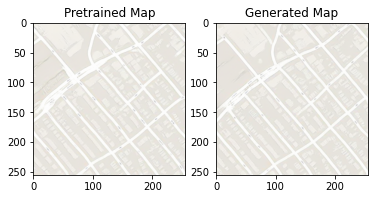

SSIM:  0.6888589966358639


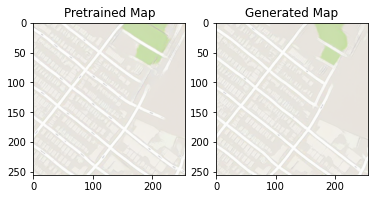

SSIM:  0.6578892141872615


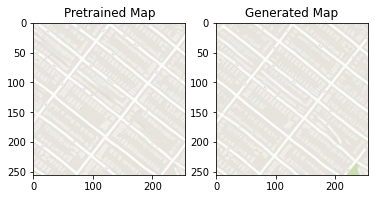

SSIM:  0.6861695106732152


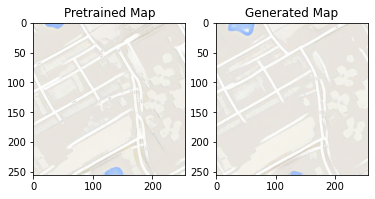

SSIM:  0.7016093657224812


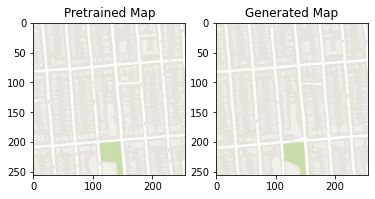

In [ ]:
import glob
import skimage.io as io
import copy
from skimage.metrics import structural_similarity as ssim
import torch

device = ("cuda:0" if torch.cuda.is_available() else "cpu")
Generator_model = torch.load("/content/drive/MyDrive/DL_Assignment_3/maps_new/Sattelite_Generator_new_final.pth")
Generator_model = Generator_model.to(device)

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 256)),
    T.CenterCrop((256, 256)),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

pretrained = sorted(glob.glob("/content/images/*"))

for img_path in pretrained:
  if img_path.split("_")[-1].split(".")[0] == "fake":
    img1 = io.imread(img_path)
    img2 = copy.deepcopy(img1)
    img2 = transform(img2)
    img2 = img2.unsqueeze(0)


    generated_img = Generator_model(img2.float().to(device))
    generated_img = generated_img.permute(0,2,3,1).detach().cpu().numpy()[0]

    SSIM = ssim(img1, generated_img, data_range=img1.max() - img1.min(),multichannel=True)
    print("SSIM: ",SSIM)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Pretrained Map')
    ax2.set_title('Generated Map')

    ax1.imshow(img1)
    ax2.imshow(generated_img)

    plt.show()



